<a href="https://colab.research.google.com/github/YUCAVALCANTE/ML_Studies/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -----------------------------
# 1) IMPORTS
# -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc
)

In [2]:
# -----------------------------
# 2) DATASET DESBALANCEADO
# -----------------------------
X, y = make_classification(
    n_samples=20000,
    n_features=10,
    n_informative=6,
    n_redundant=2,
    weights=[0.995, 0.005],  # 0.5% fraude
    random_state=42
)
print("Proporção de fraude:", y.mean())
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Proporção de fraude: 0.0101


In [3]:
# -----------------------------
# Modelo 1 - SVM Supervisionado
# -----------------------------

svm = SVC(kernel="rbf", class_weight="balanced", probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_score_svm = svm.predict_proba(X_test)[:, 1]
print("SVM Supervisionado")
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))

SVM Supervisionado
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      5939
           1       0.04      0.49      0.07        61

    accuracy                           0.87      6000
   macro avg       0.52      0.68      0.50      6000
weighted avg       0.98      0.87      0.92      6000

[[5199  740]
 [  31   30]]


In [4]:
# -----------------------------
# Modelo 2 - One-Class SVM (Semi-Supervisionado)
# -----------------------------

X_train_normal = X_train[y_train == 0]
ocsvm = OneClassSVM(kernel="rbf", gamma="scale", nu=0.01)
ocsvm.fit(X_train_normal)
y_pred_ocsvm = ocsvm.predict(X_test)
# Ajustando saída (-1 = anomalia)
y_pred_ocsvm = np.where(y_pred_ocsvm == -1, 1, 0)
print("One-Class SVM")
print(classification_report(y_test, y_pred_ocsvm))
print(confusion_matrix(y_test, y_pred_ocsvm))

One-Class SVM
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5939
           1       0.11      0.16      0.13        61

    accuracy                           0.98      6000
   macro avg       0.55      0.58      0.56      6000
weighted avg       0.98      0.98      0.98      6000

[[5861   78]
 [  51   10]]


In [5]:
# -----------------------------
# Modelo 3 - Isolation Forest (Não Supervisionado)
# -----------------------------
iso = IsolationForest(
    n_estimators=200,
    contamination=0.005,
    random_state=42
)
iso.fit(X_train)
y_pred_iso = iso.predict(X_test)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)
print("Isolation Forest")
print(classification_report(y_test, y_pred_iso))
print(confusion_matrix(y_test, y_pred_iso))

Isolation Forest
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5939
           1       0.07      0.03      0.04        61

    accuracy                           0.99      6000
   macro avg       0.53      0.51      0.52      6000
weighted avg       0.98      0.99      0.98      6000

[[5913   26]
 [  59    2]]


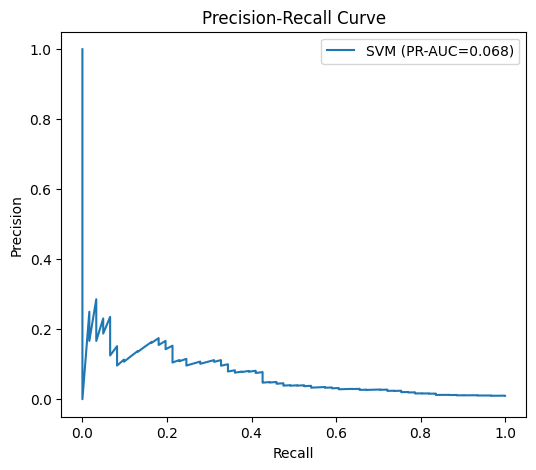

In [6]:
# -----------------------------
# Comparação via Curva Precision-Recall
# -----------------------------

precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_score_svm)
pr_auc_svm = auc(recall_svm, precision_svm)
plt.figure(figsize=(6,5))
plt.plot(recall_svm, precision_svm,
         label=f"SVM (PR-AUC={pr_auc_svm:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()